### Mode occupancy in nonlinear multimode systems

In [382]:
import matplotlib.pyplot as plt
import numpy as np

For a $m\times n$ weakly nonlinear waveguide array, the amplitude in the $m,n$-th waveguide $A_{m,n}$ over a distance $z$ is described as:

$\displaystyle i\frac{d A_{k,l}}{d z}-\kappa_1(A_{k-1,l}+A_{k+1,l})-\kappa_2(A_{k,l-1}+A_{k,l+1})-|A_{k,l}|^2A_{k,l}=0$

where $\kappa_1,\kappa_2$ are coupling coefficients in the two transverse directions.

In [383]:
m,n=20,20
A = np.zeros((m,n),dtype=np.complex128)
P = 50

As an approximation, "weakly nonlinear" means the fourth nonlinear term can be ignored.
\begin{align*}
\frac{d A_{k,l}}{d z} &= -i\kappa_1(A_{k-1,l}+A_{k+1,l})-i\kappa_2(A_{k,l-1}+A_{k,l+1})\\
\frac{d \textbf{a}}{d z} &= -iH\textbf{a}
\end{align*}
If so, such a system has $mn$ eigenvectors $\psi_i$ (for $H$), mode occupancy at the input (initial mode occupancy) can be obtained by $|c_{i0}|^2=|\langle\psi_i|\Psi\rangle|^2$, where $\Psi=(A_{1,1},A_{1,2},\ldots,A_{m,n})^T$ is called the *input complex optical field vector*.

eigenvalues $E_i=2\kappa_1\cos\left(\frac{k\pi}{m+1}\right)+2\kappa_2\cos\left(\frac{l\pi}{n+1}\right),\allowbreak\quad k,l\in\{1,2,\ldots,L\}$

eigenvectors $\psi_i$ have elements $(\psi_i)_j=\frac{2}{\sqrt{(m+1)(n+1)}}\sin\left(\frac{k\pi a}{m+1}\right)\sin\left(\frac{l\pi b}{n+1}\right)$,

where $a=j // n+1$, $b=j\%n+1$, $j=\{0,1,2,\ldots,mn-1\}$

When $\kappa_1=1,\kappa_2=1.5$, $E_i$ is bounded between $(-5,5)$, average $\overline{E}=0$

In [384]:
kappa_1,kappa_2 = 1,1.5

#### Experiment 1: 
input mode occupancy uniformly distributed between $(1,2)$

In [385]:
from math import sin,cos
def psi(i):
    # eigenvectors
    # i between 0 and m*n-1, inclusive
    k=i//n+1
    l=i%n+1
    psi_vec = np.zeros(m*n,dtype=np.complex128)
    for j in range(m*n):
        a=j//n+1
        b=j%n+1 
        psi_vec[j] = 2./((m+1)*(n+1))**.5*\
                       sin(k*np.pi*a/(m+1))*\
                        sin(l*np.pi*b/(n+1))
    return psi_vec
def E(i):
    k=i//n+1
    l=i%n+1
    return 2*kappa_1*cos(k*np.pi/(m+1))+2*kappa_2*cos(l*np.pi/(n+1))

The eigenvalues are plotted as follows:

400

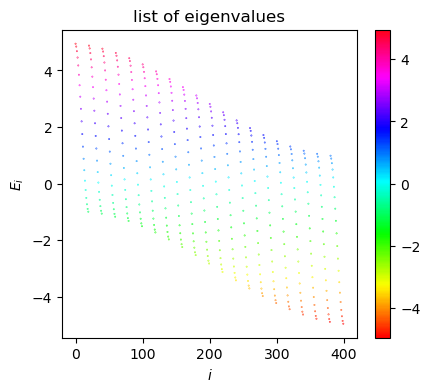

In [386]:
E_i=[]
for i in range(m*n):
    E_i.append(E(i))
plt.figure(figsize=(4.75,4))
i = np.arange(len(E_i))
plt.scatter(i,E_i,s=0.1,cmap='hsv',c=E_i)
plt.xlabel('$i$')
plt.ylabel('$E_i$')
plt.title('list of eigenvalues')
plt.colorbar()
len(E_i)

A total of 50 modes with a total occupancy of 50.0


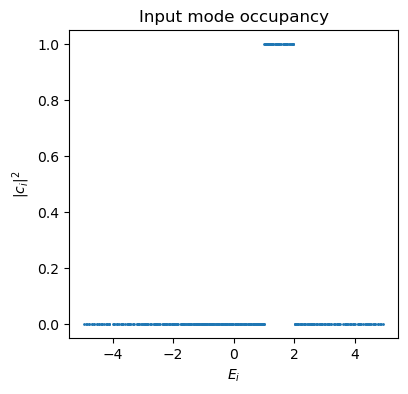

In [387]:
from random import random
def input1():
    # input mode occupancy
    number_of_modes=0
    Psi = np.zeros(m*n,dtype=np.complex128)
    mode_indices = []
    for i in range(m*n):
        if 1<E_i[i]<2:
            number_of_modes+=1
            mode_indices.append(i)
    for i in mode_indices:
        # input, uniform distribution
        # with RANDOM phase factor
        Psi += (P/number_of_modes)**.5 * psi(i) * np.exp(-1j*random())
    return Psi

Psi = input1()
mode_occupancy1 = []
for i in range(m*n):
    mode_occupancy1.append(np.square(np.abs(psi(i).dot(Psi))))
plt.figure(figsize=(4.25,4))
plt.scatter(E_i,mode_occupancy1,s=1)
plt.xlabel('$E_i$')
plt.ylabel('$|c_i|^2$')
plt.title('Input mode occupancy')
mode_occupancy1 = np.array(mode_occupancy1)
print('A total of %d modes with a total occupancy of %.1f'%(np.sum(mode_occupancy1>1e-2),np.sum(mode_occupancy1)))

Text(0.5, 1.0, 'real and imag part of input')

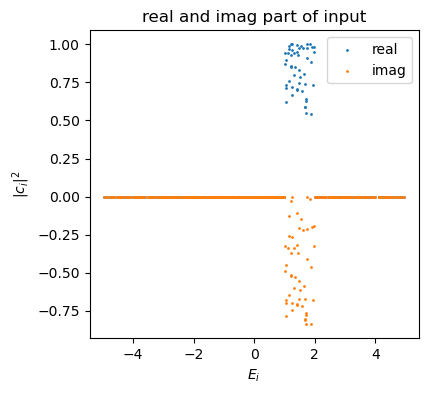

In [388]:
real_Psi = []
imag_Psi = []
for i in range(m*n):
    real_Psi.append(np.real((np.conjugate(psi(i)).dot(Psi))))
    imag_Psi.append(np.imag((np.conjugate(psi(i)).dot(Psi))))
plt.figure(figsize=(4.25,4))
plt.scatter(E_i,real_Psi,s=1,label='real')
plt.scatter(E_i,imag_Psi,s=1,label='imag')
plt.xlabel('$E_i$')
plt.ylabel('$|c_i|^2$')
plt.legend()
plt.title('real and imag part of input')

The eigenvectors are normalized and mutually orthogonal

In [389]:
print(np.sum((psi(1)*psi(1))))   # ≈ 1
print(np.sum((psi(1)*psi(2))))   # ≈ 0
print(np.sum((psi(3)*psi(48))))   # ≈ 0

(1+0j)
(-4.163336342344337e-17+0j)
(4.336808689942018e-19+0j)


Solve the IVP and observe

First, we ignore the nonlinear term in our equation, the expected solution is $\textbf{a}(z)=\textbf{T}\textbf{a}(0)$, $\textbf{T}=e^{-i\textbf{H}z}$ is the transmission

In [390]:
def kl2i(k,l):
    # we're using a flattened 1D array for a 2D lattice
    # this will convert lattice index to array index
    if k>m or k<1 or l>n or l<1:
        return -1  # the amplitude value is 0 on the edge
    k-=1
    l-=1
    return k*n+l

def i2kl(i):
    k=i//n+1
    l=i%n+1
    return k,l

Now we show the eigenvector expression is correct

c:\Users\Sol\.conda\envs\ai\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Sol\.conda\envs\ai\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, '$a$ is the eigenvector of $H$, eigenvalue 4.94')

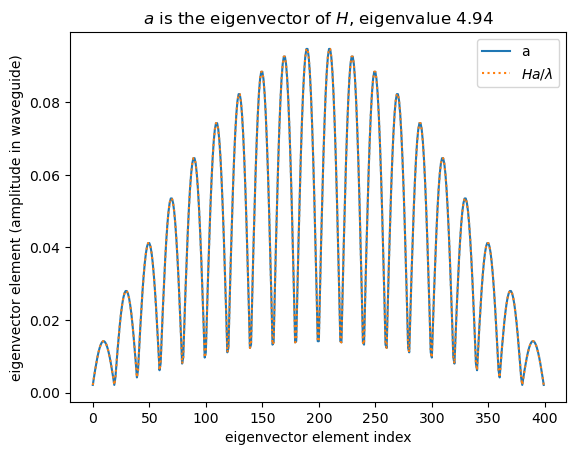

In [391]:
# change k,l to check other eigenvectors
k=1
l=1

index= (k-1)*n+(l-1)
a=psi(index)
def H(a):
    Ha = np.zeros(m*n,dtype=np.complex128)
    for i in range(m*n):
        # loop through vector elements
        k,l = i2kl(i)
        i1,i2,i3,i4 = kl2i(k-1,l), kl2i(k+1,l),kl2i(k,l-1), kl2i(k,l+1)
        a1 = (i1!=-1)*a[i1]  # if index is -1, it means k,l is outside the matrix, hence 0, as defined in kl2i(k,l)
        a2 = (i2!=-1)*a[i2]
        a3 = (i3!=-1)*a[i3]
        a4 = (i4!=-1)*a[i4]
        Ha[i] = (
            kappa_1*(a1 + a2)+\
            kappa_2*(a3 + a4)
        )
    return Ha

Ha = H(a)

plt.plot(a,label='a')
plt.plot(Ha / E(index), label='$Ha/\lambda$',linestyle='dotted')
# plt.plot(Ha,label='$Ha$')
plt.legend()
plt.xlabel('eigenvector element index')
plt.ylabel('eigenvector element (amplitude in waveguide)')
plt.title(f'$a$ is the eigenvector of $H$, eigenvalue {E(index):.2f}')

In [392]:
from scipy.integrate import solve_ivp

def input0():
    return psi(200) * P

def enforce_boundary_conditions(z,a):
    first = psi(0)
    last = psi(m*n-1)
    w1 = a.dot(first)
    w2 = a.dot(last)
    a -= w1*first
    a -= w2*last
    
    return 0  # useless return value

enforce_boundary_conditions.terminal = False  # Don't stop integration
enforce_boundary_conditions.direction = 0     # Trigger regardless of sign change

def func(z,a,):
    # our ode, ignoring the nonlinear term

    dadz = -1j * (H(a))#+0.1*np.conjugate(a).dot(a)*a)

    return dadz

z_span = [0,1e3]

# average over 50 inputs
Psi_rand = [input1() for i in range(10)]
az = []  # a(z)
for i,Psi in enumerate(Psi_rand):
    z_eval = np.linspace(*z_span, 100)
    solution = solve_ivp(func,z_span, Psi, method='RK45',t_eval=z_eval)#,events=[enforce_boundary_conditions])
    az.append(solution.y)
    if 'less' in solution.message:
        print(solution.message, f'{i+1}/{len(Psi_rand)}')
    else:
        print(solution.message, f'{i+1}/{len(Psi_rand)}',end='\r')

z = solution.t

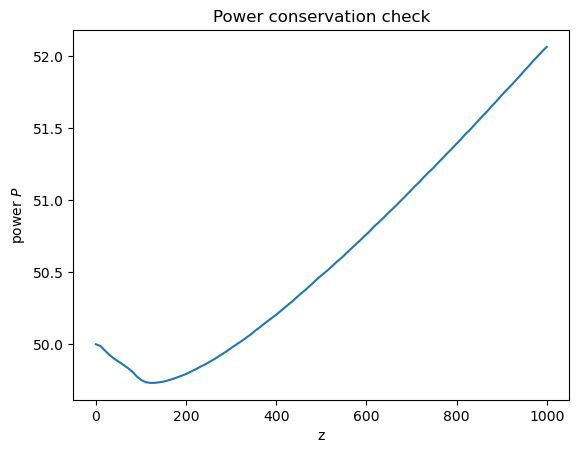

In [ ]:
occup = np.zeros((m*n,solution.t.shape[0]), dtype=np.float64)
for a_final in az:
    projection = []
    for i in range(m*n):
        temp = a_final.T.dot(psi(i))
        projection.append(temp)
    occup += np.square(np.abs(projection))

occup /= len(Psi_rand)  # average

plt.plot(solution.t, np.sum(occup,axis=0))
plt.xlabel('z')
plt.ylabel('power $P$')
plt.title('Power conservation check')
occup = occup.T

Text(0.5, 0, '$|c_i|^2$')

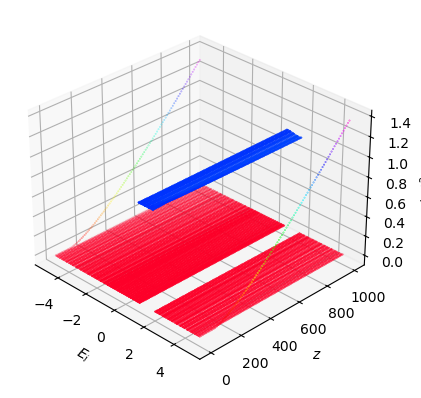

In [394]:
fig = plt.figure()

E_i=[]
for i in range(m*n):
    E_i.append(E(i))

X,Y = np.meshgrid(E_i, solution.t)
ax = fig.add_subplot(111,projection='3d')
surf = ax.scatter(X,Y,occup,s=0.1,cmap='gist_rainbow',c=occup)

ax.view_init(elev=30, azim=-45)

ax.set_xlabel('$E_i$')
ax.set_ylabel('$z$')
ax.set_zlabel('$|c_i|^2$')

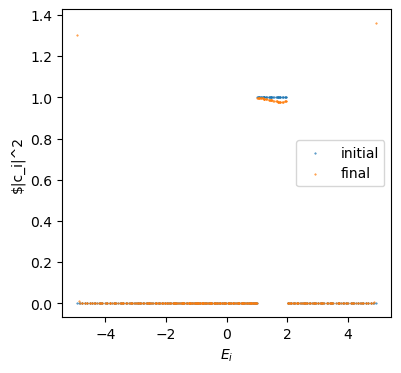

In [396]:
# initial and final distribution
plt.figure(figsize=(4.25,4))
plt.scatter(E_i,occup[0],label='initial',s=0.2)
plt.scatter(E_i,occup[-1],label='final',s=0.2)
plt.xlabel('$E_i$')
plt.ylabel('$|c_i|^2')
plt.legend()

As expected, the solution is constant, if the system is completely **linear**

(some small discrepancies due to numerical errors)

Now we add the nonlinear term

Required step size is less than spacing between numbers. 1/10
Required step size is less than spacing between numbers. 2/10
Required step size is less than spacing between numbers. 3/10
Required step size is less than spacing between numbers. 4/10
Required step size is less than spacing between numbers. 5/10
Required step size is less than spacing between numbers. 6/10
Required step size is less than spacing between numbers. 7/10
Required step size is less than spacing between numbers. 8/10
Required step size is less than spacing between numbers. 9/10
Required step size is less than spacing between numbers. 10/10


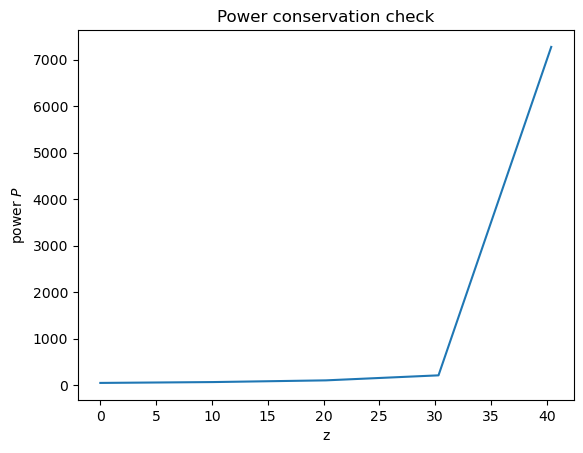

In [403]:
def func(z,a,):
    # our ode, ignoring the nonlinear term

    dadz = -1j * (H(a)+0.1*np.conjugate(a).dot(a)*a)

    return dadz

z_span = [0,1e3]

# average over 50 inputs
Psi_rand = [input1() for i in range(10)]
az = []  # a(z)
for i,Psi in enumerate(Psi_rand):
    z_eval = np.linspace(*z_span, 100)
    solution = solve_ivp(func,z_span, Psi, method='RK45',t_eval=z_eval)#,events=[enforce_boundary_conditions])
    az.append(solution.y)
    if 'less' in solution.message:
        print(solution.message, f'{i+1}/{len(Psi_rand)}')
    else:
        print(solution.message, f'{i+1}/{len(Psi_rand)}',end='\r')

z = solution.t

In [ ]:
occup = np.zeros((m*n,solution.t.shape[0]), dtype=np.float64)
for a_final in az:
    projection = []
    for i in range(m*n):
        temp = a_final.T.dot(psi(i))
        projection.append(temp)
    occup += np.square(np.abs(projection))

occup /= len(Psi_rand)  # average

plt.plot(solution.t, np.sum(occup,axis=0))
plt.xlabel('z')
plt.ylabel('power $P$')
plt.title('Power conservation check')
occup = occup.T

Text(0.5, 0, '$|c_i|^2$')

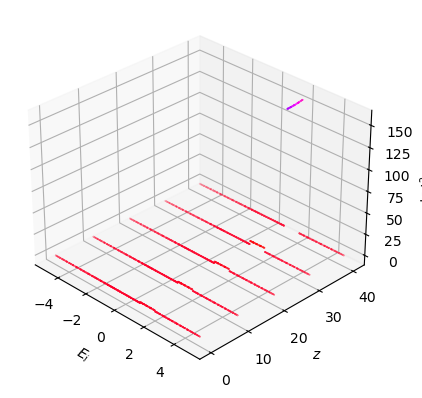

In [404]:
fig = plt.figure()

E_i=[]
for i in range(m*n):
    E_i.append(E(i))

X,Y = np.meshgrid(E_i, solution.t)
ax = fig.add_subplot(111,projection='3d')
surf = ax.scatter(X,Y,occup,s=0.1,cmap='gist_rainbow',c=occup)

ax.view_init(elev=30, azim=-45)

ax.set_xlabel('$E_i$')
ax.set_ylabel('$z$')
ax.set_zlabel('$|c_i|^2$')

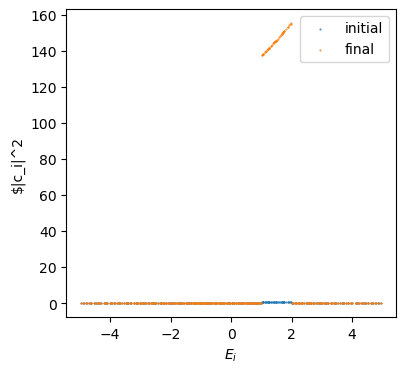

In [405]:
# initial and final distribution
plt.figure(figsize=(4.25,4))
plt.scatter(E_i,occup[0],label='initial',s=0.2)
plt.scatter(E_i,occup[-1],label='final',s=0.2)
plt.xlabel('$E_i$')
plt.ylabel('$|c_i|^2')
plt.legend()

#### A huge flop

After days of futile efforts, I have to stop.

The nonlinear term makes solution diverge quickly, probably due to the abnormal behaviour of $0$ and $m\times n-1$-th mode in previous linear solutions.

Even tried to set the two modes to 0 in every step, to force them like a boundary condition, it only makes more modes nearby to diverge too.

I can't see why

Without the nonlinear part, the equation can be solved exactly.

Each mode evolves as $e^{-i\textbf{H}z}\psi_i=e^{-iE_i z}\psi_i$

(400,)


Text(0.5, 0.92, 'Mode occupancy against $E_i$ over $z$')

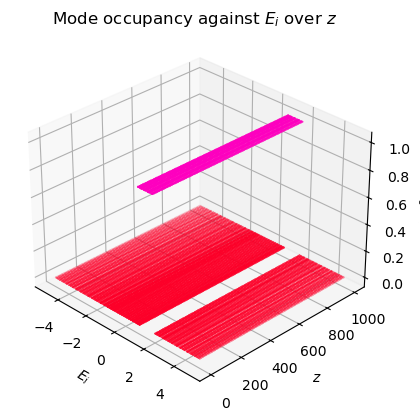

In [406]:
E_i=[]
for i in range(m*n):
    E_i.append(E(i))

Psi = input1()
print(Psi.shape)
weights = []
psis = []
for i in range(m*n):
    psis.append(psi(i))
    weights.append(psis[i].dot(Psi))

z = np.linspace(0,1000,100)
az = np.zeros((m*n,len(z)),dtype=np.complex128)
for w,p in zip(weights,psis):
    az += w * np.outer(p,np.exp(-1j*E(i)*z))

occup = []
for i in range(m*n):
    temp = az.T.dot(psi(i))
    occup.append(temp)
occup = np.square(np.abs(occup))
occup = occup.T

fig = plt.figure()
X,Y = np.meshgrid(E_i, z)
ax = fig.add_subplot(111,projection='3d')
surf = ax.scatter(X,Y,occup,s=0.1,cmap='gist_rainbow',c=occup)

ax.view_init(elev=30, azim=-45)

ax.set_xlabel('$E_i$')
ax.set_ylabel('$z$')
ax.set_zlabel('$|c_i|^2$')
ax.set_title('Mode occupancy against $E_i$ over $z$')

I wonder why the linear solution found numerically does not match this.

Numerical error or some neglected factors in mode decomposition?

#### An issue with the theory

$\langle\Psi|\Psi\rangle=\sum_i |c_i|^2=P$ should be constant at all times, but to satisfy the governing equation, $\frac{d P}{d t}=\frac{d \langle\Psi|\Psi\rangle}{d t}=\sum_{k,l}\langle A_{k,l}|\frac{d A_{k,l}}{d t}\rangle+\langle\frac{d A_{k,l}}{d t}|A_{k,l}\rangle\not\equiv 0$